# Models Demo == TensorFlow 2.0

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.datasets.samples_generator import make_classification
import os
from matplotlib import pyplot
import pandas as pd
%matplotlib inline

In [2]:
def np_dataset(mode, n_samples):
    x, y = make_classification(n_samples=n_samples, 
                               n_features=2, 
                               n_redundant=0, 
                               n_classes=3, 
                               n_clusters_per_class=1, 
                               random_state=7)
    train_len = int(0.9 * n_samples)
    train_x, train_y = x[:train_len], y[:train_len]
    val_x, val_y = x[train_len:], y[train_len:]
    
    if mode=='all':
        return  x, y
    elif mode == tf.estimator.ModeKeys.TRAIN:
        return train_x, train_y
    elif mode == tf.estimator.ModeKeys.EVAL:
        return val_x, val_y

# Create dataset and plot it

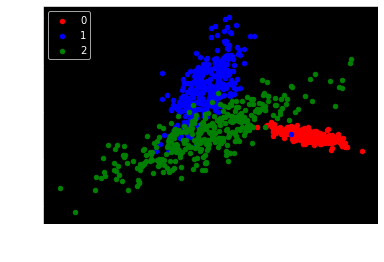

In [3]:
X, y = np_dataset(n_samples=1000, mode='all')
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

# Create TensorFlow dataset

In [4]:
def simple_dataset(mode, n_samples=1000):
    print(mode)
    x, y = np_dataset(mode, n_samples)

    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices(tensors=(x_tensor, y_tensor))
    if mode == tf.estimator.ModeKeys.TRAIN:
        #dataset = dataset.repeat(10)
        dataset = dataset.shuffle(len(x))
    dataset = dataset.batch(16)
    return dataset

# Create TensorFlow keras Model

In [5]:
params = {'learning_rate': 0.01}

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.sigmoid)
        self.fc2 = tf.keras.layers.Dense(units=3)
        
    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x        

In [7]:
mymodel = MyModel()

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

# Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

eval_loss = tf.keras.metrics.Mean(name='eval_loss')
eval_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [9]:
def train_step(sample):
    with tf.GradientTape() as tape:
        features, labels = sample
        logits = mymodel(features)

        batch_loss = loss_object(y_pred=logits, y_true=labels)
        loss = tf.reduce_sum(batch_loss) / 16 # i.e. batch_size
    
    gradients = tape.gradient(loss, mymodel.trainable_variables)
    optimizer.apply_gradients(zip(gradients, mymodel.trainable_variables))
    
    train_loss(loss)
    train_accuracy(y_true=labels, y_pred=logits)    

In [10]:
def eval_step(sample):
    features, labels = sample
    logits = mymodel(features)

    batch_loss = loss_object(y_pred=logits, y_true=labels)
    loss = tf.reduce_sum(batch_loss) / 16 # i.e. batch_size
    
    predictions = tf.nn.softmax(logits)
    
    eval_loss(loss)
    eval_accuracy(y_true=labels, y_pred=predictions)

In [11]:
num_epochs = 50

In [12]:
ds = simple_dataset(mode=tf.estimator.ModeKeys.TRAIN)
ds_eval = simple_dataset(mode=tf.estimator.ModeKeys.EVAL)

train
eval


In [13]:
for i in range(num_epochs):
    for sample in ds:
        train_step(sample)
    
    
    for sample in ds_eval:
        eval_step(sample)       
    
    print(f"Epoch {i+1}, Mean Train Loss: {train_loss.result()}, Mean Train Acc: {train_accuracy.result()}, Eval Loss: {eval_loss.result()}, Eval Acc: {eval_accuracy.result()}")
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    eval_loss.reset_states()
    eval_accuracy.reset_states()

Epoch 1, Mean Train Loss: 1.103846549987793, Mean Train Acc: 0.40444445610046387, Eval Loss: 1.0226051807403564, Eval Acc: 0.5299999713897705
Epoch 2, Mean Train Loss: 1.0228456258773804, Mean Train Acc: 0.6688888669013977, Eval Loss: 0.9482256174087524, Eval Acc: 0.5299999713897705
Epoch 3, Mean Train Loss: 0.9661219120025635, Mean Train Acc: 0.6711111068725586, Eval Loss: 0.8969826102256775, Eval Acc: 0.5299999713897705
Epoch 4, Mean Train Loss: 0.919233500957489, Mean Train Acc: 0.6766666769981384, Eval Loss: 0.8567757606506348, Eval Acc: 0.5299999713897705
Epoch 5, Mean Train Loss: 0.8773905038833618, Mean Train Acc: 0.6800000071525574, Eval Loss: 0.8214804530143738, Eval Acc: 0.5299999713897705
Epoch 6, Mean Train Loss: 0.8395256400108337, Mean Train Acc: 0.6777777671813965, Eval Loss: 0.7882853150367737, Eval Acc: 0.5400000214576721
Epoch 7, Mean Train Loss: 0.8049250245094299, Mean Train Acc: 0.7177777886390686, Eval Loss: 0.7618069648742676, Eval Acc: 0.5899999737739563
Epoch 8

## Predict and verify graphically

In [14]:
def predict_dataset():
    x = np.linspace(-4, 4, 50)
    y = np.linspace(-4, 4, 50)
    coords_x, coords_y = np.meshgrid(x, y)
    res = np.stack([np.array(coords_x), np.array(coords_y)], axis=-1)
    res = np.reshape(res, newshape=(-1, 2))
    res = tf.convert_to_tensor(res, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices(tensors=(res))
    dataset = dataset.batch(16)
    return dataset

In [15]:
test_ds = predict_dataset()

In [16]:
x_pred = []
cls_pred = []

for sample in test_ds:
    output = mymodel(sample)
    pred = tf.nn.softmax(output)
    cls_idx = tf.argmax(pred, axis=-1)
    
    x_pred.append(sample.numpy())
    cls_pred.append(cls_idx.numpy())

In [17]:
x_pred = np.concatenate(x_pred, axis=0)
cls_pred = np.concatenate(cls_pred, axis=0)

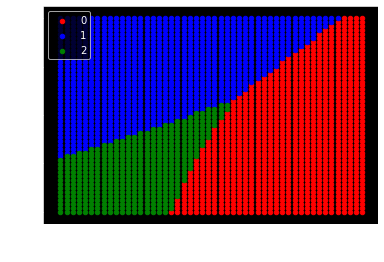

In [18]:
df = pd.DataFrame(dict(x=x_pred[:,0], y=x_pred[:,1], label=cls_pred))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()